## import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
import os
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,Dropout,BatchNormalization,Conv2DTranspose,concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Create Indeed Functions

In [2]:
basepath='/kaggle/input/kidney-segmentation-dataset/2d segmentation dataset/2d segmentation dataset'

def explore_dir(path):
   for dir,dirname,files in os.walk(path):

      if 'mask' not in dir:
         print(f'There are {len(dirname)} directories and {len(files)} images in {dir}')
      else:
           print(f'There are {len(dirname)} directories and {len(files)} masks in {dir}')

def check_filetypes(path):
   ext=[]
   ext=[file.split('/')[0].split('.')[-1] for dir,dirnames,files in os.walk(path) for file in files]
   return set(ext)



def create_df(path):
  img_path=[]
  mask_path=[]
  df=pd.DataFrame(columns=['img_path','mask_path'])
  for dir in os.listdir(path):
     dirpath=os.path.join(path,dir)
     for file in os.listdir(dirpath):
         file_path=os.path.join(dirpath,file)
         if 'masks' in file_path:

            mask_path.append(file_path)
         else :
             img_path.append(file_path)

     # Ensure lengths match
  # if len(img_path) == len(mask_path):
  df['img_path'] = img_path
  df['mask_path'] = mask_path

  return df


df=create_df(basepath)


In [3]:
df

,img_path,mask_path
0,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
1,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
2,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
3,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
4,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
...,...,...
2022,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
2023,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
2024,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...
2025,/kaggle/input/kidney-segmentation-dataset/2d s...,/kaggle/input/kidney-segmentation-dataset/2d s...


## Explore Data

In [4]:
explore_dir(basepath)
check_filetypes(basepath)

There are 2 directories and 0 images in /kaggle/input/kidney-segmentation-dataset/2d segmentation dataset/2d segmentation dataset
There are 0 directories and 2027 images in /kaggle/input/kidney-segmentation-dataset/2d segmentation dataset/2d segmentation dataset/images
There are 0 directories and 2027 masks in /kaggle/input/kidney-segmentation-dataset/2d segmentation dataset/2d segmentation dataset/masks


{'png'}

## Show Some Samples!

In [5]:
def display(df):
  random_indices = np.random.choice(df.index, size=10, replace=False)
  random_images = df.iloc[random_indices]['img_path'].values
  random_masks = df.iloc[random_indices]['mask_path'].values
  plt.figure(figsize=(12,12))
  plt.suptitle('Randomly Kidney images with their mask')
  for i in range(10):

     plt.subplot(5,4,2*i+1)

     image = cv2.imread(random_images[i])
     #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
     mask=cv2.imread(random_masks[i],cv2.IMREAD_GRAYSCALE)
     print(image.shape)
     print(mask.shape)
     plt.imshow(image)
     plt.title('image')
     plt.axis('off')
     plt.grid(True)

     plt.subplot(5,4,2*i+2)
     plt.imshow(mask,cmap='gray')
     plt.title('mask')
     plt.axis('off')
     plt.grid(True)
  plt.tight_layout()
  plt.show()


(170, 170, 3)
(170, 170)
(130, 130, 3)
(130, 130)
(160, 160, 3)
(160, 160)
(142, 142, 3)
(142, 142)
(189, 189, 3)
(189, 189)
(160, 160, 3)
(160, 160)
(138, 138, 3)
(138, 138)
(141, 141, 3)
(141, 141)
(139, 139, 3)
(139, 139)
(139, 139, 3)
(139, 139)


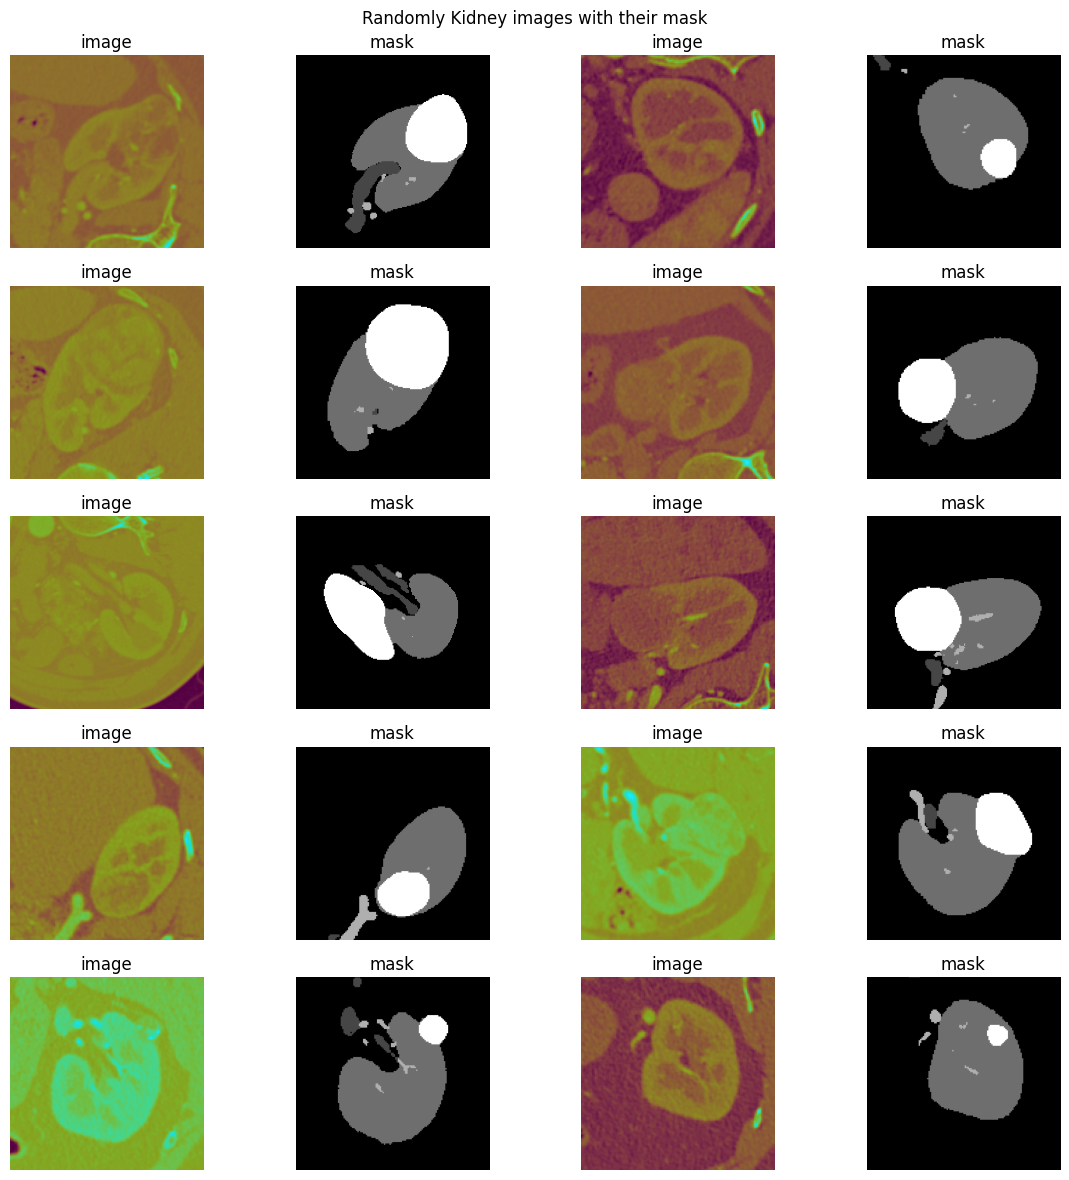

In [6]:
display(df)

## Split Data

In [7]:
train_df,test_df=train_test_split(df,test_size=0.1,random_state=42)
train_df,val_df=train_test_split(train_df,test_size=0.1,random_state=42)

In [8]:
len(train_df)

1641

## Create Image Generator

In [9]:
def create_image_generator(data_frame,
    batch_size,

    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,):

    def normalize(img,mask):
      img=img/255.0
      mask=mask/255.0
      mask[mask>0.5]=1
      mask[mask<=0.5]=0
      return img,mask




    image_gen=ImageDataGenerator()
    mask_gen=ImageDataGenerator()



    img_gen=image_gen.flow_from_dataframe(
        dataframe=data_frame,
        x_col='img_path',
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed)

    mask_gen=mask_gen.flow_from_dataframe(
        dataframe=data_frame,
        x_col='mask_path',
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed)


    combined_gen=zip(img_gen,mask_gen)

    for img,mask in combined_gen:
      yield normalize(img,mask)




## Set Constants

In [10]:
EPOCHS = 40
BATCH_SIZE = 32
learning_rate = 1e-4
w,h=256,256

In [11]:
train_gen=create_image_generator(train_df,batch_size=BATCH_SIZE,target_size=(w,h))
val_gen=create_image_generator(val_df,batch_size=BATCH_SIZE,target_size=(w,h))
test_gen=create_image_generator(test_df,batch_size=BATCH_SIZE,target_size=(w,h))

## Build Unet Architcure

In [12]:
def double_conv(x,n_filters):
    x=layers.Conv2D(n_filters,3,padding='same',activation='relu')(x)
    x=layers.Conv2D(n_filters,3,padding='same',activation='relu')(x)
    x=layers.BatchNormalization()(x)
    return x

def encoder(x,n_filters):
   x=double_conv(x,n_filters)
   p=layers.MaxPool2D((2,2))(x)
   return x,p

def decoder(x,skip_connection,n_filters):

    x=Conv2DTranspose(n_filters,3,strides=2,padding='same')(x)

    h_diff = skip_connection.shape[1] - x.shape[1]
    w_diff = skip_connection.shape[2] - x.shape[2]

    if h_diff != 0 or w_diff != 0:
        skip_connection = layers.Cropping2D(((h_diff // 2, h_diff - h_diff // 2),
                                             (w_diff // 2, w_diff - w_diff // 2)))(skip_connection)

    x=layers.Concatenate()([x,skip_connection])

    x=double_conv(x,n_filters)

    return x


def Unet(input_shape):
  inputs=Input(input_shape)

  # downsampling

  s1,p1=encoder(inputs,64)
  s2,p2=encoder(p1,128)
  s3,p3=encoder(p2,256)
  s4,p4=encoder(p3,512)

  #bottelneck

  b=double_conv(p4,1024)

  #upsampling

  b1=decoder(b,s4,512)
  b2=decoder(b1,s3,256)
  b3=decoder(b2,s2,128)
  b4=decoder(b3,s1,64)


  outputs=layers.Conv2D(1,1,padding='same',activation='sigmoid')(b4)

  model=Model(inputs,outputs,name='U-net')

  return model




### Evaluation Matrix

In [13]:
def Coffiecient_dice(y_true,y_pred,smooth=100):
   y_true=K.flatten(y_true)
   y_pred=K.flatten(y_pred)
   intersection=K.sum(y_true*y_pred)
   union=K.sum(y_true)+K.sum(y_pred)
   dice=(2 * intersection + smooth) / (union +smooth)

   return dice

def Dice_loss(y_true,y_pred) :
   return -Coffiecient_dice(y_true,y_pred)


def Iou(y_true,y_pred,smooth=100):
   y_true=K.flatten(y_true)
   y_pred=K.flatten(y_pred)
   intersection=K.sum(y_pred * y_true)
   union=K.sum(y_true+y_pred)

   iou=  (intersection +smooth)/(union - intersection + smooth)
   return iou

def Iou_loss(y_true,y_pred):
    return -Iou(y_true,y_pred)

In [14]:
model=Unet((w,h,3))
model.summary()

Model: "U-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 34,525,121 (131.70 MB)

 Trainable params: 34,519,233 (131.68 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [15]:
optim=keras.optimizers.Adam(learning_rate)

model.compile(optimizer=optim,loss=Dice_loss,metrics=[Iou,Coffiecient_dice])

In [16]:
steps_per_epoch=len(train_df)//BATCH_SIZE
val_steps=len(val_df)//BATCH_SIZE
history=model.fit(train_gen,batch_size=BATCH_SIZE,steps_per_epoch=steps_per_epoch,validation_data=val_gen,
                  validation_steps=val_steps,epochs=EPOCHS,verbose=1)

Found 1641 validated image filenames.
Found 1641 validated image filenames.
Epoch 1/40


I0000 00:00:1727549737.740636      68 service.cc:145] XLA service 0x79b680002990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727549737.740729      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727549804.257271      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - coffiecient_dice: 0.2685 - iou: 0.1582 - loss: -0.2685Found 183 validated image filenames.
Found 183 validated image filenames.
51/51 ━━━━━━━━━━━━━━━━━━━━ 116s 791ms/step - coffiecient_dice: 0.2700 - iou: 0.1592 - loss: -0.2700 - val_coffiecient_dice: 0.1509 - val_iou: 0.0817 - val_loss: -0.1509
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - coffiecient_dice: 0.4900 - iou: 0.3258 - loss: -0.4889 - val_coffiecient_dice: 0.1497 - val_iou: 0.0811 - val_loss: -0.1496
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 740ms/step - coffiecient_dice: 0.6085 - iou: 0.4393 - loss: -0.6133 - val_coffiecient_dice: 0.0374 - val_iou: 0.0191 - val_loss: -0.0374
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 740ms/step - coffiecient_dice: 0.7219 - iou: 0.5668 - loss: -0.7190 - val_coffiecient_dice: 0.1541 - val_iou: 0.0837 - val_loss: -0.1527
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 739ms/step - coffiecient_dice: 0.7846 - iou: 0.6477 - loss: -0.7871 - val_coffiecien

## Evaluate The Model

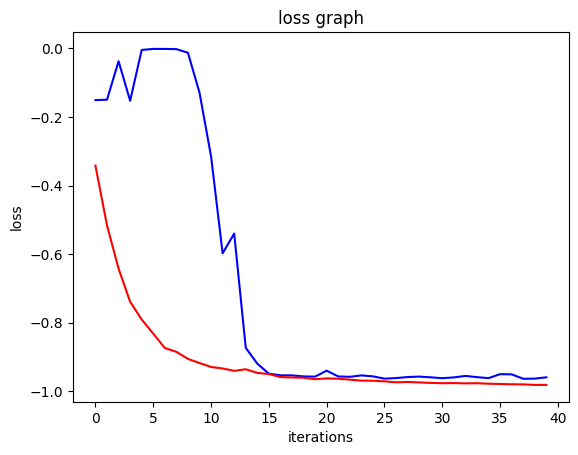

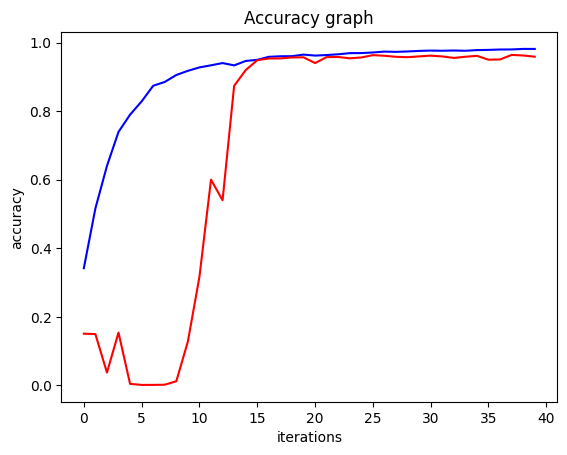

In [17]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['coffiecient_dice']
test_dice_coeff_list = history_post_training['val_coffiecient_dice']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

## Load Model

In [18]:
#model=tensorflow.keras.models.load_model('/content/drive/MyDrive/kidney segmenation/model.keras',custom_objects={'Dice_loss':Dice_loss,'Iou':Iou,'Coffiecient_dice':Coffiecient_dice})

## Get Predictions

In [19]:
def get_prediction(df):

  indecies=np.random.choice(len(df),size=4,replace=False)

  fig,ax=plt.subplots(4,3,figsize=(10,10))
  k=0
  for i,index in  enumerate(indecies):

      img=df.iloc[index]['img_path']
      mask=df.iloc[index]['mask_path']


      #preprocess image
      img=cv2.imread(img)
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img=img/255.0
      img=cv2.resize(img,(w,h))

      mask=cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
      mask=mask/255.0
      mask=cv2.resize(mask,(w,h))

      # get prediction
      img_input=np.expand_dims(img,axis=0)
      pred_mask=model.predict(img_input)

      pred_mask=np.squeeze(pred_mask,axis=0)>=0.5
      # pred_mask[pred_mask>=0.5]=1
      # pred_mask[pred_mask<0.5]=0


      ax[i,0].imshow(img)
      ax[i,0].set_title('image')
      ax[i,0].grid(True)

      ax[i,1].imshow(mask,cmap='gray')
      ax[i,1].set_title('mask')
      ax[i,1].grid(True)

      ax[i,2].imshow(pred_mask,cmap='gray')
      ax[i,2].set_title('predicted mask')
      ax[i,2].grid(True)
  plt.tight_layout()
  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


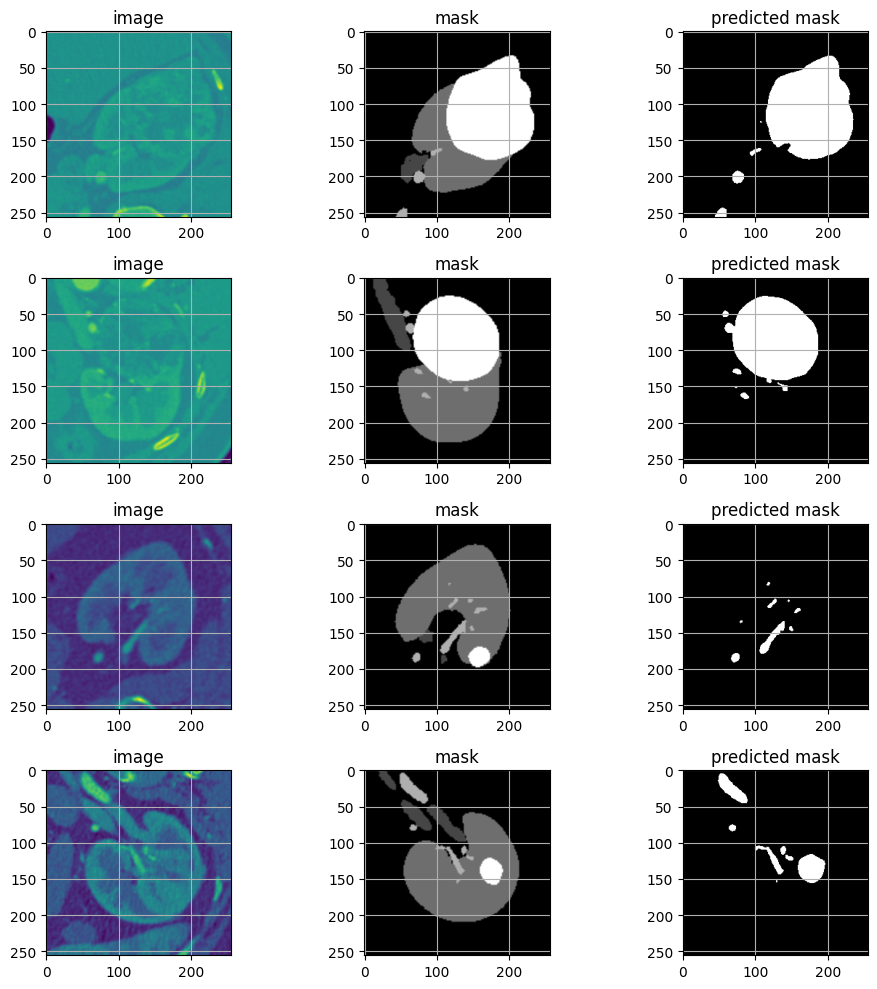

In [20]:
get_prediction(test_df)